In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import sys, importlib
sys.path.append("/content/drive/MyDrive/SA_CropType_SourceCoop")

import common
importlib.reload(common)
from common import *

ensure_dirs()

print("BASE_DIR:", BASE_DIR)
print("S2_DIR exists:", S2_DIR.exists())
print("META_DIR:", META_DIR)
print("FIG_DIR:", FIG_DIR)

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop
S2_DIR exists: True
META_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta
FIG_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os, json
from tqdm import tqdm

In [ ]:
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Drive mount (gerekliyse)
from google.colab import drive
drive.mount('/content/drive')

BASE = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")

S2_DIR = BASE / "train" / "imagery" / "s2"
OUT_FIG = BASE / "outputs" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

print("S2_DIR exists:", S2_DIR.exists(), "|", S2_DIR)
print("OUT_FIG:", OUT_FIG)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
S2_DIR exists: True | /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s2
OUT_FIG: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures


In [ ]:
def find_band_file(tile_id: int, date: str, suffix: str) -> Path:
    """
    suffix örnekleri:
      "B02_10m.tif", "B03_10m.tif", "B04_10m.tif", "B08_10m.tif", "CLM_10m.tif"
    """
    tile_dir = S2_DIR / str(tile_id) / date
    if not tile_dir.exists():
        raise FileNotFoundError(f"Tile/date klasörü yok: {tile_dir}")
    pattern = f"{tile_id}_{date}_{suffix}"
    p = tile_dir / pattern
    if not p.exists():
        # bazen isimler farklı olabilir diye fallback:
        hits = list(tile_dir.glob(f"*_{suffix}"))
        if len(hits) == 1:
            return hits[0]
        raise FileNotFoundError(f"Band bulunamadı: {p} | fallback hits={len(hits)}")
    return p

def read_band(path: Path) -> np.ndarray:
    with rasterio.open(path) as src:
        arr = src.read(1)
    return arr

def safe_norm01(x: np.ndarray, p_low=2, p_high=98):
    """RGB için hafif percentile stretch (görsel amaçlı)."""
    x = x.astype(np.float32)
    lo = np.percentile(x, p_low)
    hi = np.percentile(x, p_high)
    if hi <= lo:
        return np.zeros_like(x, dtype=np.float32)
    y = (x - lo) / (hi - lo)
    return np.clip(y, 0, 1)

def compute_ndvi(b04: np.ndarray, b08: np.ndarray) -> np.ndarray:
    b04 = b04.astype(np.float32)
    b08 = b08.astype(np.float32)
    ndvi = (b08 - b04) / (b08 + b04 + 1e-6)
    return ndvi


In [ ]:
def infer_cloud_value_from_rgb(clm: np.ndarray, rgb: np.ndarray):
    """
    clm içinde genelde {0,255} var.
    Bulutlar RGB’de daha parlak görünür → parlak olan sınıfı 'cloud' sayıyoruz.
    rgb: HxWx3, 0..1 arası
    """
    vals = np.unique(clm)
    vals = vals[(vals == 0) | (vals == 255)]
    if len(vals) < 2:
        # tek değer varsa bulut bilgisi yok/boş
        return None, {"reason": "single_value_clm", "unique": np.unique(clm).tolist()}

    # parlaklık (luma) yaklaşık
    lum = 0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]

    m0 = lum[clm == 0].mean() if np.any(clm == 0) else -1
    m255 = lum[clm == 255].mean() if np.any(clm == 255) else -1

    cloud_value = 0 if m0 > m255 else 255
    info = {"mean_lum_clm0": float(m0), "mean_lum_clm255": float(m255), "cloud_value": int(cloud_value)}
    return cloud_value, info

In [ ]:
def make_rgb(tile_id: int, date: str):
    """
    RGB üretmek için B04/B03/B02 kullanıyoruz.
    Eğer bu bantlar yoksa hata verir.
    """
    b02 = read_band(find_band_file(tile_id, date, "B02_10m.tif"))
    b03 = read_band(find_band_file(tile_id, date, "B03_10m.tif"))
    b04 = read_band(find_band_file(tile_id, date, "B04_10m.tif"))

    r = safe_norm01(b04)
    g = safe_norm01(b03)
    b = safe_norm01(b02)
    rgb = np.stack([r,g,b], axis=-1)
    return rgb

def visualize_date(tile_id: int, date: str):
    print(f"\n🛰️ Görselleştiriliyor: tile={tile_id}, date={date}")

    # gerekli bantlar
    b04_path = find_band_file(tile_id, date, "B04_10m.tif")
    b08_path = find_band_file(tile_id, date, "B08_10m.tif")
    clm_path = find_band_file(tile_id, date, "CLM_10m.tif")

    b04 = read_band(b04_path)
    b08 = read_band(b08_path)
    clm = read_band(clm_path).astype(np.uint8)

    ndvi = compute_ndvi(b04, b08)

    # RGB (overlay için)
    rgb = make_rgb(tile_id, date)

    # Bulut değeri otomatik tespit
    cloud_value, info = infer_cloud_value_from_rgb(clm, rgb)

    uniq, cnt = np.unique(clm, return_counts=True)
    uniq_stats = dict(zip([int(u) for u in uniq], [int(c) for c in cnt]))
    print("CLM uniq counts:", uniq_stats)
    if cloud_value is None:
        print("⚠️ CLM tek değer -> bu tile/date için gerçek bulut bilgisi yok gibi. Maske uygulanmayacak.")
        cloud_mask = np.zeros_like(clm, dtype=bool)
    else:
        print("Bulut otomatik tespit:", info)
        cloud_mask = (clm == cloud_value)

    ndvi_masked = ndvi.copy()
    ndvi_masked[cloud_mask] = np.nan

    cloud_ratio = float(cloud_mask.mean())
    nan_ratio = float(np.isnan(ndvi_masked).mean())
    print(f"cloud_ratio={cloud_ratio:.4f} | NaN_ratio(masked NDVI)={nan_ratio:.4f}")

    # --- (A) CLM + NDVI + NDVI(maskeli) ---
    plt.figure(figsize=(16,5))
    plt.subplot(1,3,1)
    plt.imshow(clm, cmap="gray")
    plt.title(f"CLM | tile={tile_id} | {date}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(ndvi, vmin=-1, vmax=1, cmap="viridis")
    plt.title("NDVI (masksiz)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(ndvi_masked, vmin=-1, vmax=1, cmap="viridis")
    plt.title("NDVI (CLM maskeli)")
    plt.axis("off")

    plt.tight_layout()
    out1 = OUT_FIG / f"nb7_tile{tile_id}_{date}_clm_ndvi_triplet.png"
    plt.savefig(out1, dpi=160)
    plt.show()
    print("✅ Kaydedildi:", out1)

    # --- (B) SENİN SEVDİĞİN: RGB + overlay CLM==0 ve CLM==255 ---
    # Burada amaç: CLM değerleri RGB’de nereye denk geliyor gör.
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.imshow(rgb)
    plt.title(f"RGB | tile={tile_id} | {date}")
    plt.axis("off")

    # CLM==0 overlay
    mask0 = (clm == 0)
    plt.subplot(1,3,2)
    plt.imshow(rgb)
    plt.imshow(mask0, alpha=0.35)  # varsayılan colormap ile “highlight” gibi durur
    plt.title("Overlay: CLM==0 alanları")
    plt.axis("off")

    # CLM==255 overlay
    mask255 = (clm == 255)
    plt.subplot(1,3,3)
    plt.imshow(rgb)
    plt.imshow(mask255, alpha=0.35)
    plt.title("Overlay: CLM==255 alanları")
    plt.axis("off")

    plt.tight_layout()
    out2 = OUT_FIG / f"nb7_tile{tile_id}_{date}_rgb_clm_overlays.png"
    plt.savefig(out2, dpi=160)
    plt.show()
    print("✅ Kaydedildi:", out2)



🛰️ Görselleştiriliyor: tile=100, date=2017_08_24
CLM uniq counts: {0: 1536, 255: 64000}
Bulut otomatik tespit: {'mean_lum_clm0': 0.05038578435778618, 'mean_lum_clm255': 0.43218740820884705, 'cloud_value': 255}
cloud_ratio=0.9766 | NaN_ratio(masked NDVI)=0.9766


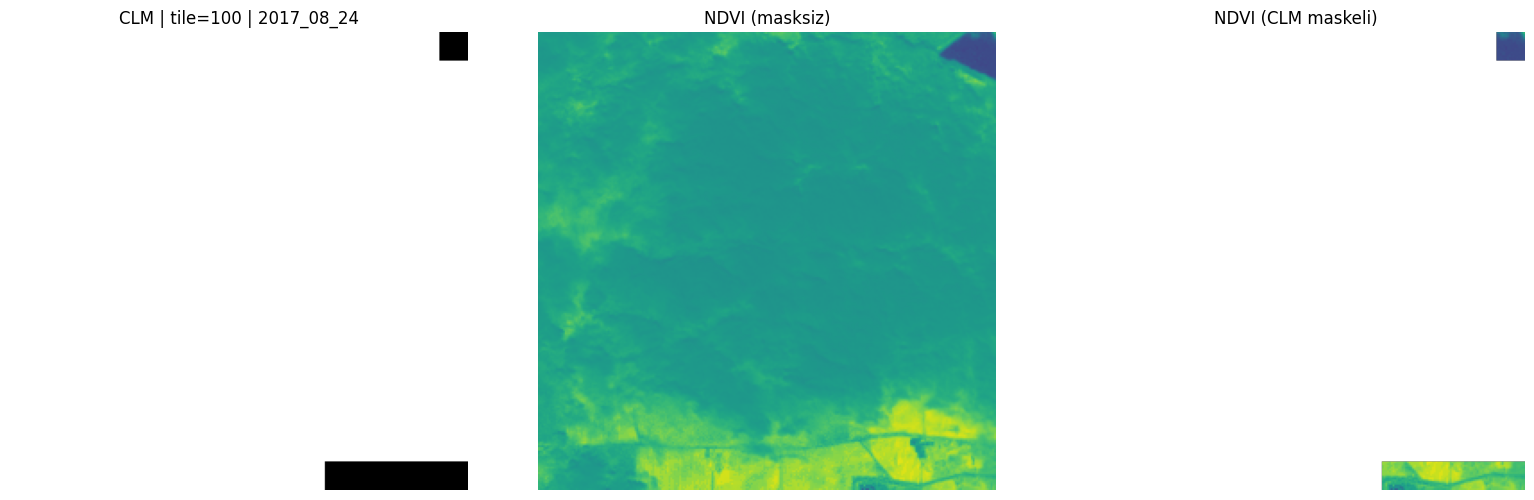

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/nb7_tile100_2017_08_24_clm_ndvi_triplet.png


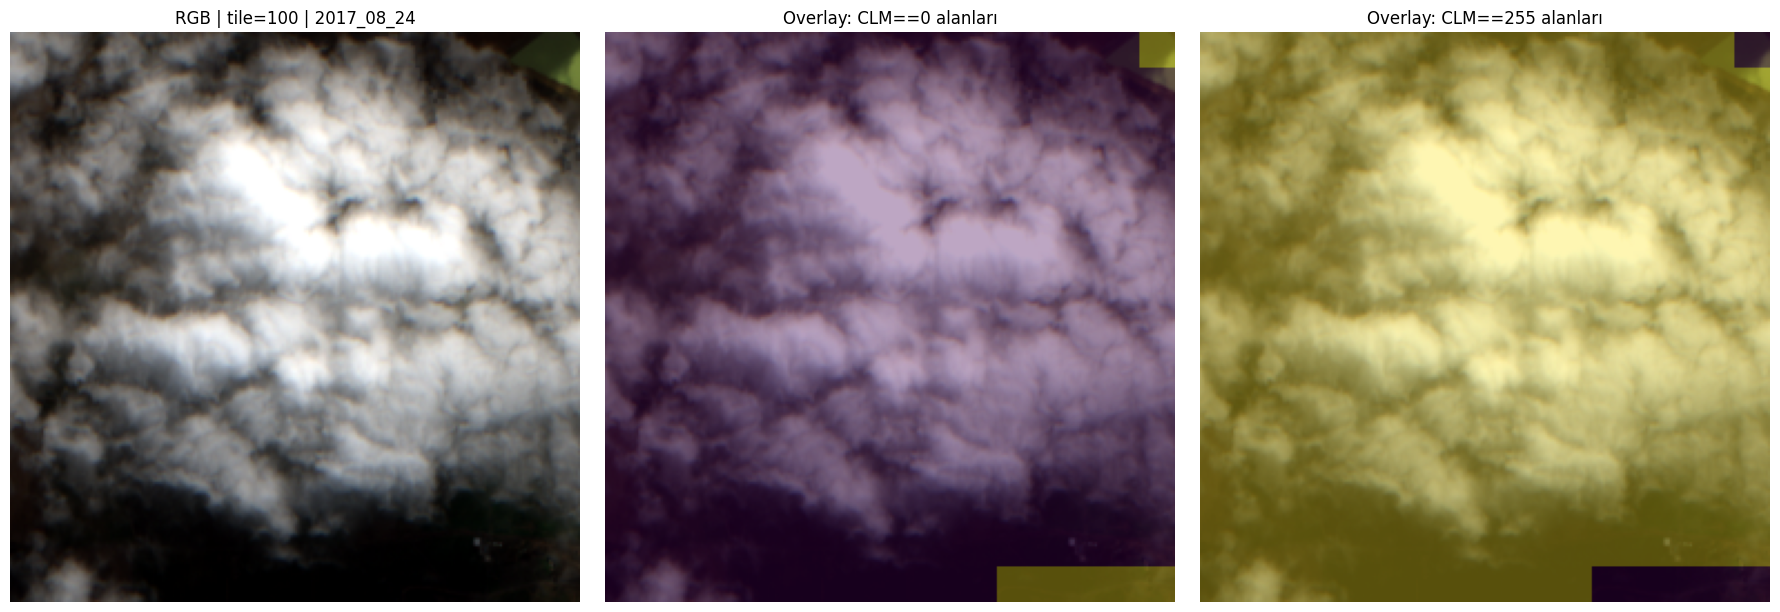

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/nb7_tile100_2017_08_24_rgb_clm_overlays.png


In [ ]:
tile_id = 100
dates = ["2017_08_24"]

for d in dates:
    visualize_date(tile_id, d)


🛰️ Görselleştiriliyor: tile=100, date=2017_11_12
CLM uniq counts: {0: 34816, 255: 30720}
Bulut otomatik tespit: {'mean_lum_clm0': 0.4213857054710388, 'mean_lum_clm255': 0.5127790570259094, 'cloud_value': 255}
cloud_ratio=0.4688 | NaN_ratio(masked NDVI)=0.4688


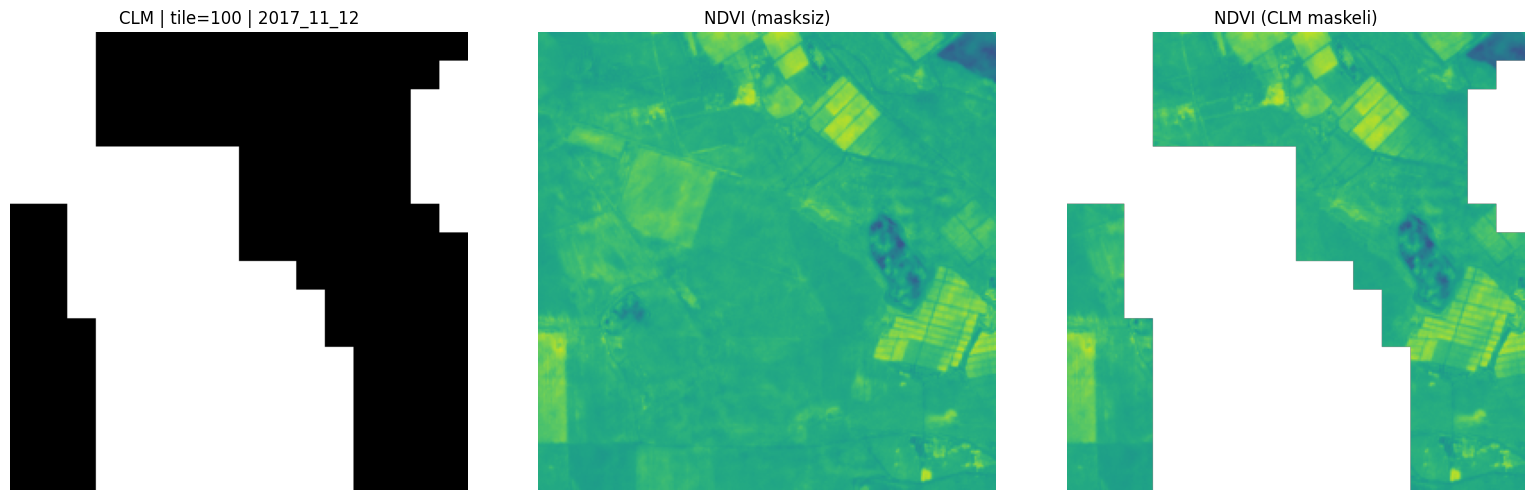

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/nb7_tile100_2017_11_12_clm_ndvi_triplet.png


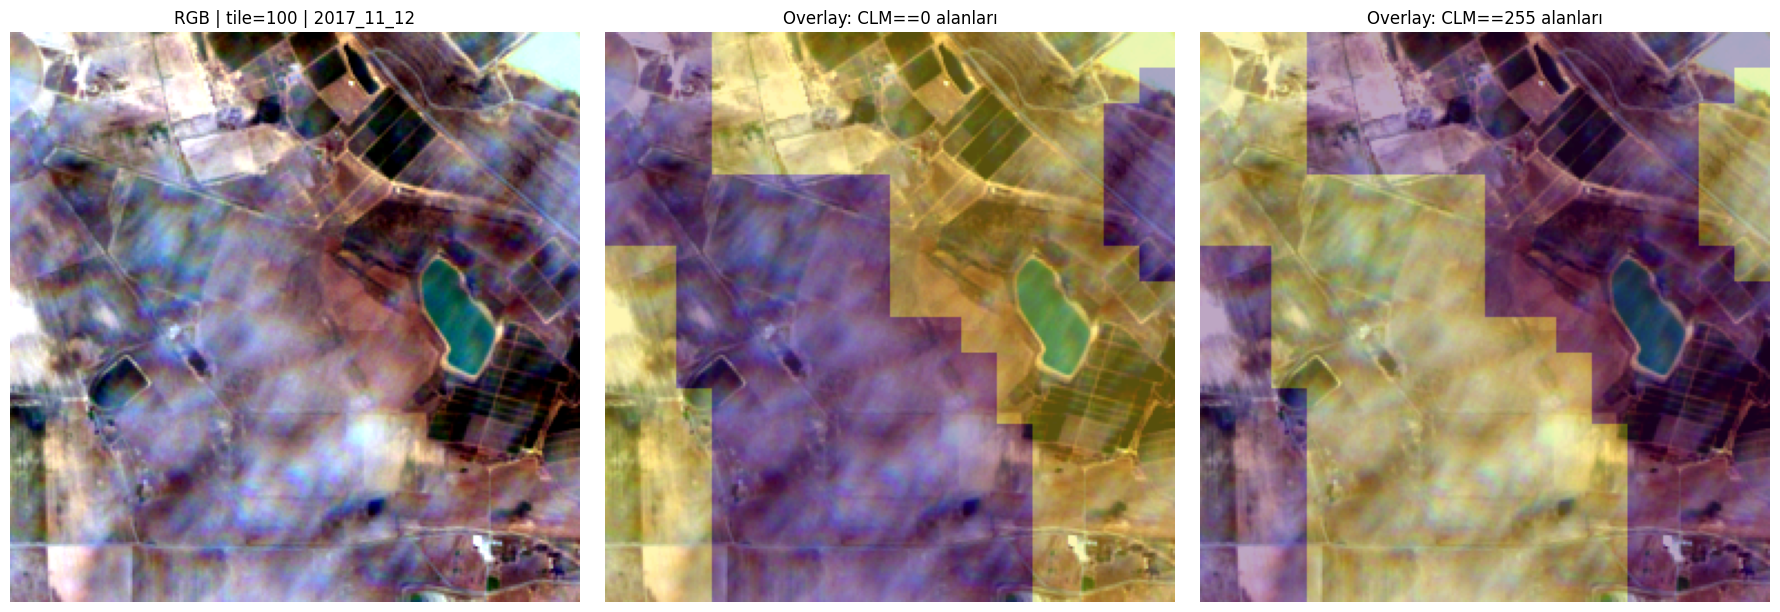

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/nb7_tile100_2017_11_12_rgb_clm_overlays.png


In [ ]:
tile_id = 100
dates = ["2017_11_12"]

for d in dates:
    visualize_date(tile_id, d)